Нужно установить scikit-image:
    
   ```pip install scikit-image```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce

In [2]:
img = plt.imread('cat.jpeg', format='jpeg') / 255
img.shape

(480, 600, 3)

## Напишем функцию для свертки и для визуализации

Возьмем ядра с википедии и посмотрим как это работает

https://ru.wikipedia.org/wiki/Ядро_свертки

In [3]:
def apply_func_rgb(img, func, *args, **kwargs):
    new_images = [func(img[:, :, i], *args, **kwargs) for i in range(3)]
    return np.stack(new_images, axis=2)

    
def conv_rgb_img(img, kernel):
    """Применяем свертку к каждому каналу в RGB"""
    return apply_func_rgb(img, convolve2d, kernel)


def apply_conv_multiple(img, kernel, times=1):
    """Применяем свертку times раз"""
    for i in range(times):
        img = conv_rgb_img(img, kernel)
    return img

In [4]:
def show_rgb_by_channel(img, grey=True):
    """Показываем 3 картинки по каналам RGB"""
    fig, ax = plt.subplots(1, 3)
    colors = ['red', 'green', 'blue']
    cmaps = ['Reds', 'Greens', 'Blues']
    for i, (cmap, color) in enumerate(zip(cmaps, colors)):
        if grey:
            cmap = 'Greys'
        ax[i].imshow(img[:, :, i], cmap=cmap)
        ax[i].set_title(color)
    
def show_rgb_images(*images):
    """Показываем RGB картинки в одну строку"""
    fig, ax = plt.subplots(1, len(images))
    for i in range(len(images)):
        ax[i].imshow(images[i])

In [5]:
def normalize_image(img):
    """Оставляем изображение в рамках [0; 1]"""
    return np.clip(img, 0, 1)
    # return np.clip(img, 0, 255).astype(int)

### Выделение контуров

In [6]:
edge_detecting = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

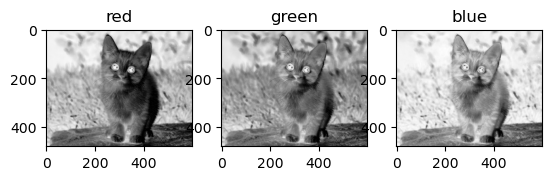

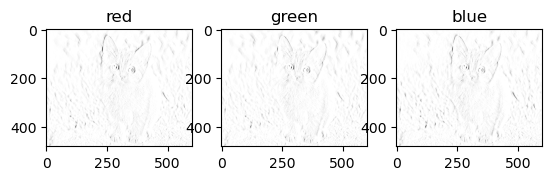

In [7]:
show_rgb_by_channel(img)
convolved = apply_conv_multiple(img, edge_detecting, 1)
convolved = normalize_image(convolved)
show_rgb_by_channel(convolved)

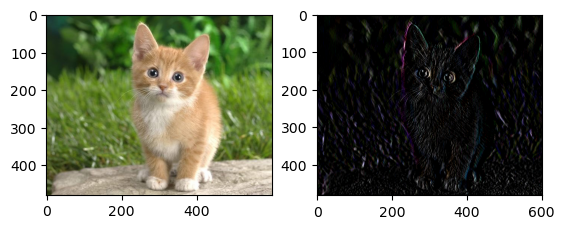

In [8]:
show_rgb_images(img, convolved)
# plt.imshow(convolved)

### Резкость

In [9]:
sharpness = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

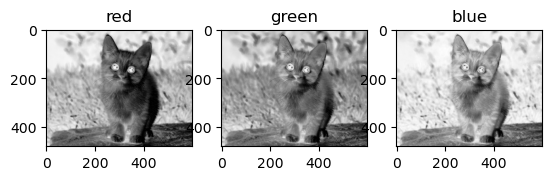

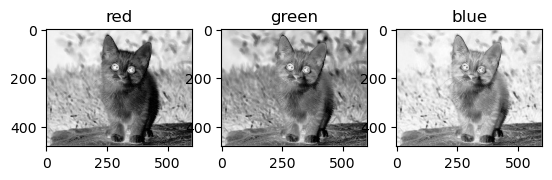

In [10]:
show_rgb_by_channel(img)
convolved = apply_conv_multiple(img, sharpness, 1)
convolved = normalize_image(convolved)
show_rgb_by_channel(convolved)

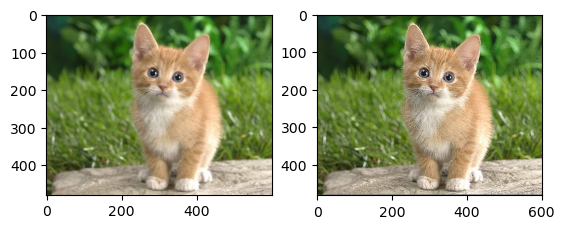

In [11]:
show_rgb_images(img, convolved)

## Размытие по Гауссу

In [12]:
blurring = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) * (1/16)

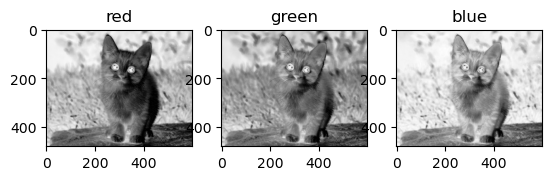

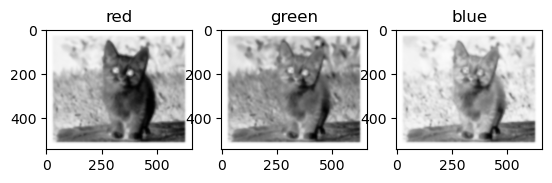

In [13]:
show_rgb_by_channel(img)
convolved = apply_conv_multiple(img, blurring, 30)
convolved = normalize_image(convolved)
show_rgb_by_channel(convolved)

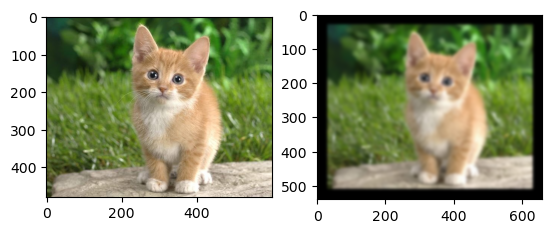

In [14]:
show_rgb_images(img, convolved)

# Пайплайн из сверток

In [15]:
kernels = [
    blurring,
    blurring,
    sharpness,
    sharpness,
    edge_detecting
]

In [16]:
def apply_kernels(img, kernels):
    for kernel in kernels:
        img = conv_rgb_img(img, kernel)
    img = normalize_image(img)
    return img

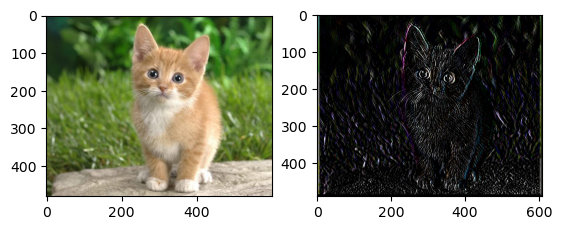

In [17]:
convolved = apply_kernels(img, kernels)
show_rgb_images(img, convolved)

# Пулинг

Уменьшим изображение, чтобы выкинуть ненужные пиксели

In [18]:
block_reduce(img[:, :, 0], (2,2), np.max)

array([[0.10588235, 0.10196078, 0.10588235, ..., 0.18431373, 0.20392157,
        0.27058824],
       [0.10980392, 0.10588235, 0.10588235, ..., 0.21176471, 0.21960784,
        0.27843137],
       [0.11372549, 0.10588235, 0.10196078, ..., 0.24313725, 0.23921569,
        0.27843137],
       ...,
       [0.16470588, 0.15294118, 0.14901961, ..., 0.71764706, 0.80392157,
        0.86666667],
       [0.16470588, 0.16862745, 0.17254902, ..., 0.82352941, 0.78431373,
        0.74901961],
       [0.2       , 0.22352941, 0.22352941, ..., 0.85882353, 0.77647059,
        0.80784314]])

In [19]:
def max_pool_rgb(img):
    return apply_func_rgb(img, block_reduce, (2,2), np.max)

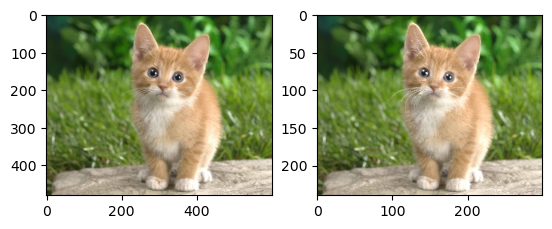

In [20]:
pooled = max_pool_rgb(img)
show_rgb_images(img, pooled)

In [21]:
img.shape, pooled.shape

((480, 600, 3), (240, 300, 3))

# Применим свертки и пулинг вместе

Будем применять пулинг после каждой свертки

In [22]:
def apply_kernels_with_pooling(img, kernels):
    for kernel in kernels:
        img = conv_rgb_img(img, kernel)
        img = max_pool_rgb(img)
    img = normalize_image(img)
    return img

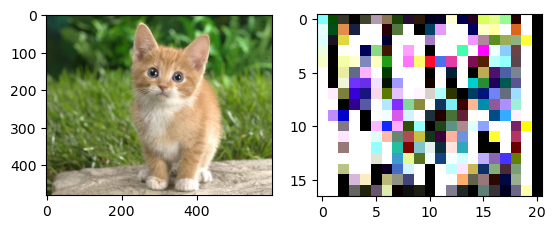

In [23]:
kernels = [
    blurring,
    blurring,
    sharpness,
    sharpness,
    edge_detecting
]

processed_img = apply_kernels_with_pooling(img, kernels)
show_rgb_images(img, processed_img)

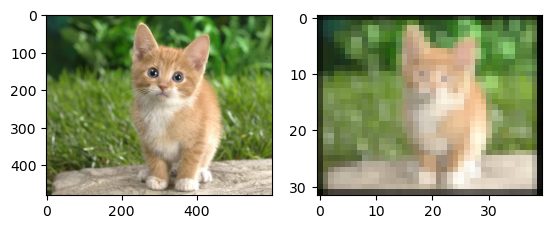

In [24]:
kernels = [
    blurring,
    blurring,
    blurring,
    blurring,
]

processed_img = apply_kernels_with_pooling(img, kernels)
show_rgb_images(img, processed_img)

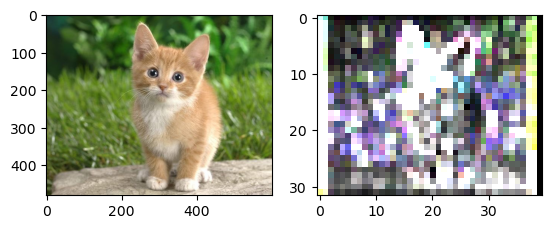

In [25]:
kernels = [
    edge_detecting,
    sharpness,
    edge_detecting,
    blurring
]

processed_img = apply_kernels_with_pooling(img, kernels)
show_rgb_images(img, processed_img)

# Сегодня свертки подбираются автоматически

Сверточные нейросети (CNN - convolutional neural network) - это алгоритм, который подбирает свертки так, чтобы лучшим образом решать задачи над картинками

## Несколько трюков

1. Функция активации - сигмоида
2. ReLU
3. BatchNorm
4. SkipConnections

## Сигмоида

После каждой свертки будем применять сигмоиду

In [26]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_to_rgb(img):
    """Применяем сигмоиду к каждому каналу в RGB"""
    return apply_func_rgb(img, sigmoid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


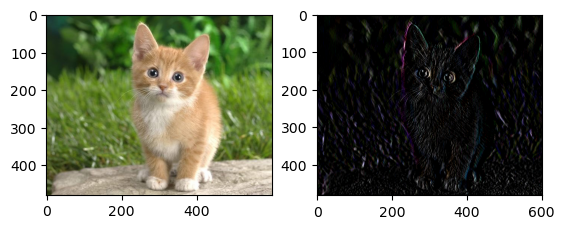

In [27]:
show_rgb_images(img, conv_rgb_img(img, edge_detecting))

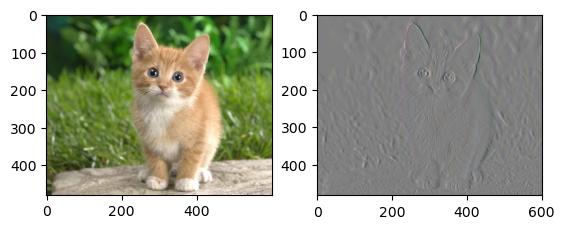

In [28]:
show_rgb_images(img, sigmoid_to_rgb(conv_rgb_img(img, edge_detecting)))

In [29]:
def apply_kernels_with_pooling_sigmoid(img, kernels):
    for kernel in kernels:
        img = conv_rgb_img(img, kernel)
        img = sigmoid_to_rgb(img)
        img = max_pool_rgb(img)
    img = normalize_image(img)
    return img

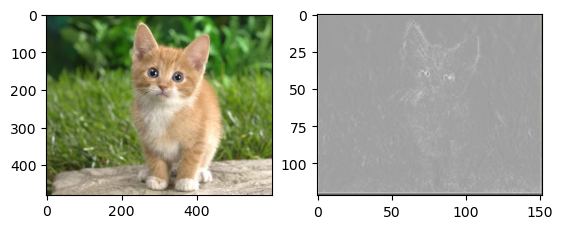

In [30]:
kernels = [
    edge_detecting,
    sharpness,
]

processed_img = apply_kernels_with_pooling_sigmoid(img, kernels)
show_rgb_images(img, processed_img)

## Выглядит не очень

\- подумали исследователи и стали использовать ReLU

In [31]:
def relu(x):
    return x * (x > 0)

def relu_to_rgb(img):
    """Применяем сигмоиду к каждому каналу в RGB"""
    return apply_func_rgb(img, relu)

def apply_kernels_with_pooling_relu(img, kernels):
    for kernel in kernels:
        img = conv_rgb_img(img, kernel)
        img = relu_to_rgb(img)
        img = max_pool_rgb(img)
    img = normalize_image(img)
    return img

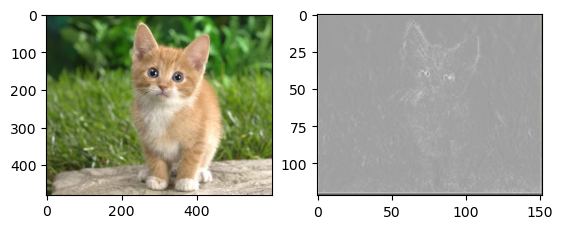

In [32]:
kernels = [
    edge_detecting,
    sharpness,
]

processed_img = apply_kernels_with_pooling_sigmoid(img, kernels)
show_rgb_images(img, processed_img)

На глаз разница не видна, но оно работает лучше.

## BatchNorm

- Нейросети учатся батчами (по несколько картинок за раз)
- После каждой свертки и активации распределение пикселей меняется, из-за этого усложняется обучение

После каждого шага будем:
1. делать нормализацию

$$\hat{x} = \frac{x - x_{avg}}{x_{std}}$$

2. растягивать и сдвигать на "оптимальное" расстояние

$$y = \hat{x} * \gamma + \beta$$

Гамма и бета - подбираемые параметры

# Skip Connections

"Visualizing the loss landscape of neural nets"

![](../images/skip_connections.png)

Еще одна штука, которая упрощает оптимизацию. Идея в том, чтобы модель могла сама оценить, насколько полезен очередной слой.

![](../images/resnet.png)